# Geographically Weighted Regression (GWR)

Nous avons vu la régression linéaire simple qui peut prendre la forme suivante:

$$Y = \beta_0 + \beta_1 X + \epsilon$$

où $Y$ est la variable dépendante, et $X$ la variable indépendante. La régression décrit la relation linéaire qui peut exister entre la variable dépendante et les variables indépendantes.

## L'hétérogénéité spatiale

Dans le cas où nous avons des données spatiales, on peut s'imaginer que **la relation linéaire décrite par la régression n'est pas identique à chaque endroit.** C'est ce qu'on appelle l'hétérogénéité spatiale.

Concrètement, si on prend par exemple la relation entre le prix des appartements (variable dépendante) et la surface habitable (variable indépendante), on peut s'imaginer que cette relation est différente en ville par rapport à la campagne, ou encore qu'il y a des différences entre cantons.

## La régession pondérée

La solution au problème de l'hétérogénéité spatiale est de faire une régression localement, par rapport à une localisation précise. Ceci peut se faire à travers une **pondération** de chaque individu **en fonction de la distance par rapport au point de régression**.

De manière générale, une **régression pondérée** permet de donner plus de poids à certains individus qu'à d'autres. Si la pondération est 0, l'individu y relatif est de fait éliminé de la régression.

## La pondération géographique

Le poids de chaque individu dans la régression pondérée peut être déterminé en fonction de la distance par rapport à **un point de référence** (le point de régression). Ce poids est en principe une valeur entre 0 et 1, déterminé à l'aide d'une fonction qui définit la relation entre le poids $w_ij$ de l'individu $j$ et la distance au point de régression $i$:

$$w_{ij} = f(d_ij)$$

En théorie, n'importe quelle fonction continue qui donne des valeurs entre 0 et 1 pourrait être utilisée pour déterminer ces poids. En pratique, on se sert généralement d'une fonction de type gaussien, appelée aussi un noyau gaussian (Gaussian kernel function), qui prend la forme suivante:

$$w_{ij} = e^{-\frac{d_{ij}^2}{2 \cdot b^2}}$$

où $b$ est le paramètre de la *bandwidth* qui doit être spécifié par l'utilisateur. La bandwidth détermine la portée du noyau, c'est-à-dire jusqu'à quelle distance on veut condisérer les données. La figure ci-dessous montre la forme d'un tel noyau gaussien:

![](figures/gaussian-kernel.png)  
*Source: Fotheringham et al. 2002, p. 44*

## Geographically Weighted Regression (GWR)

Le principe du GWR est de faire une régression pondérée localement à un point de régression, et de répéter la régression à plusieurs points de régression. Ces points de régression peuvent être localisés aux mêmes endroits que les points de données, ou sur une grille régulière, ou encore autre chose.

La figure ci-dessous montre ce principe:

![](figures/gwr-fixed-kernel.png)  
*Source: Fotheringham et al. 2002, p.45*

Dans la version la plus simple, la taille du noyau (la bandwidth) reste la même à travers toute la région. D'autres variantes permettent de faire varier la taille du noyau, p.ex. en considérant au minimum un certain nombre de points de données.

De manière générale, nous allons parler du GWR comme étant un **modèle pondéré spatialement**, tandis qu'un modèle de régression classique est appelé un **modèle globale**, du fait de proposer des paramètres de régression globalement.

## Un exemple de GWR: le prix des appartements

Par la suite, nous allons faire un exemple typique de calcul de GWR, avec un jeu de données qui contient les loyers de presque 15'000 appartements à travers toute la Suisse, ainsi que la surface habitable et le nombre de pièces. Nous allons essayer d'estimer le loyer en fonction de la surface habitable et regarder si nous trouvons des différences dans l'espace.

Nous allons suivre ici en gros un tutoriel par Chris Brunsdon qui est disponible [ici](https://rpubs.com/chrisbrunsdon/101305), sauf que nous utilisons un autre jeu de données.

### Installation des packages

Tout d'abord nous installons les packages R nécessaires. Nous utilisons ici le package [GWmodel](https://cran.r-project.org/web/packages/GWmodel/index.html), mais d'autres packages existent pour faire du GWR, comme [gwrr](https://cran.r-project.org/web/packages/gwrr/index.html), [lctools](https://cran.r-project.org/web/packages/lctools/index.html), ou encore [spgwr](https://cran.r-project.org/web/packages/spgwr/index.html).

In [ ]:
install.packages(c('GWmodel', 'sp'))

In [2]:
library(GWmodel)

### Lecture des données

In [6]:
d = read.csv(file='appartements.tsv', sep='\t')
head(d, 3)

adv_id,lat,lng,nombre_pieces,surface_habitable,loyer_mois
100513760,47.36522,8.564631,1.0,30,2300
101524704,47.35651,7.984905,4.5,87,1390
102182223,46.20270,6.165245,3.0,60,3200


### Un premier modèle global

Pour commencer, nous allons calculer une régression linéaire simple pour l'ensemble du jeu de données:

In [7]:
mod_glob = lm(loyer_mois ~ surface_habitable ,data=d)
summary(mod_glob)


Call:
lm(formula = loyer_mois ~ surface_habitable, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-5181.4  -326.0   -84.8   170.8  8718.6 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       120.0696    14.0963   8.518   <2e-16 ***
surface_habitable  20.5378     0.1497 137.209   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 692.5 on 14570 degrees of freedom
Multiple R-squared:  0.5637,	Adjusted R-squared:  0.5637 
F-statistic: 1.883e+04 on 1 and 14570 DF,  p-value: < 2.2e-16


où on arrive à un $R^2$ de 0.56. Sur un graphique, on peut voir malgré la surcharge totale d'informations les différents appartements et la droite de régression:

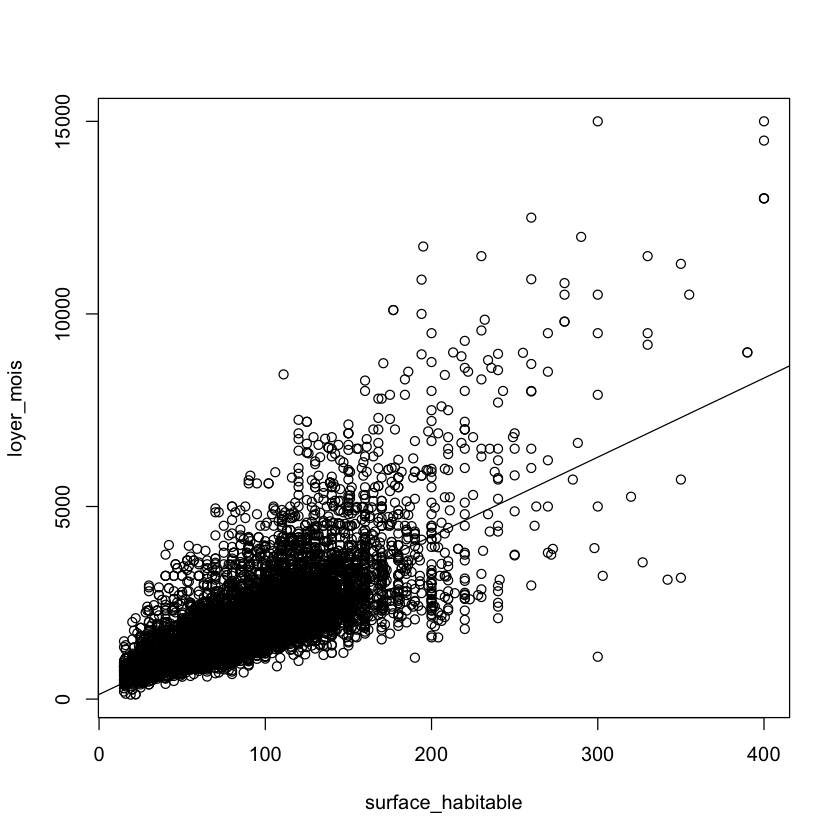

In [8]:
plot(loyer_mois ~ surface_habitable, data=d)
abline(mod_glob)

### Analyser la présence de l'hétérogénéité spatiale

Une question importante avec GWR est d'analyser si la relation analysée avec la régression varie dans l'espace ou non. Si aucune variation n'est présente, le GWR n'est pas nécessaire et un simple modèle global fait l'affaire.

Une façon assez simple d'analyser la présence d'une variation spatiale est le *coplot* défini par Cleveland (1993). En gros, dans ce graphique, la région étudiée est divisiée en plusieurs parties selon les coordonnées, et une régression partielle est faite sur les points localisés dans les différentes parties.

Voici comment faire le graphique:

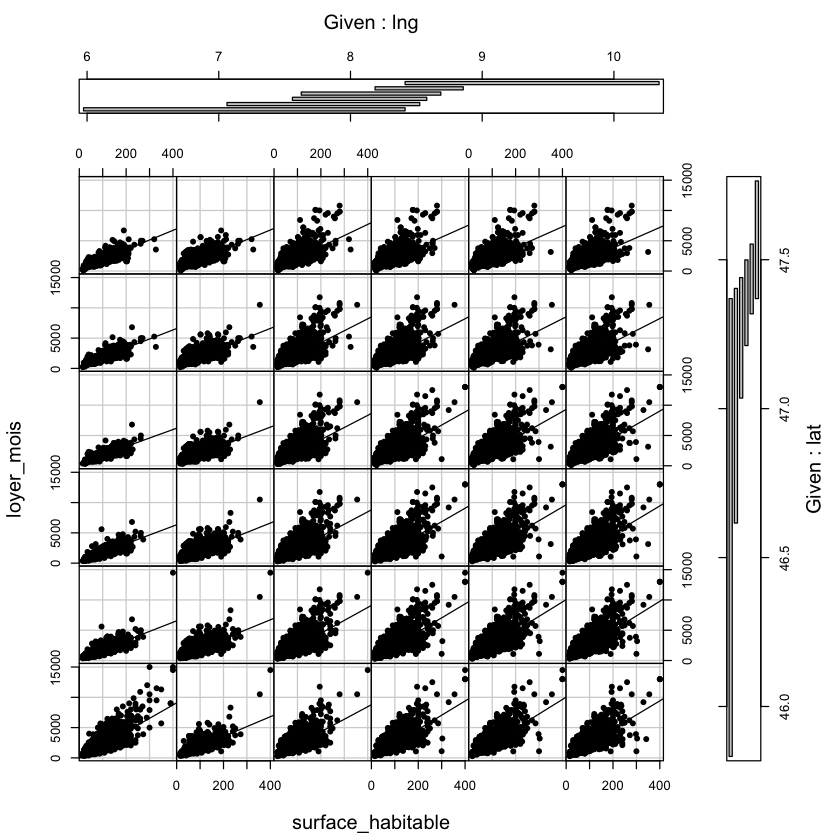

In [10]:
panel.lm <- function(x,y,...) {
  points(x, y, pch=16)
  abline(lm(y~x))
}
coplot(loyer_mois ~ surface_habitable | lng*lat, data=d, panel=panel.lm, overlap=0.8)

En regardant le graphique, on constate une certaine variabilité dans la pente de la droite de régression, ce qui est une indication de présence d'hétérogénéité spatiale.

### Transformer les données en données spatiales

Nous avons lu notre fichier des appartements depuis un fichier CSV. Le problème avec ça est que R ne saura pas qu'il s'agit de données spatiales, et quelles sont les coordonnées des points ou quel système de référence spatial est utilisé. Nous devons en conséquence transformer notre tableau de données (sous forme d'un *data frame*) en tableau spatial (un *spatial data frame*). Ceci peut se faire en indiquant les coordonnées des points séparément, et en fournissant ce système de référence spatial:

In [63]:
apparts_spat = SpatialPointsDataFrame(
    coords = data.frame(x=d$lng, y=d$lat), 
    data = d,
    proj4string = CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
)

Le texte `"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"` est la définition formelle du SRS WGS84 qui peut être trouvée sur le site [spatialreference.org](http://spatialreference.org/). Pour le WGS84, le lien direct est [http://spatialreference.org/ref/epsg/wgs-84/](http://spatialreference.org/ref/epsg/wgs-84/). Le texte lui-même peut être trouvé en cliquant sur *Proj4* dans l'encart en bas à gauche (3ème option du haut).

### Une première visualisation des données

Nous pouvons visualiser la localisation des appartements par rapport à une couche des cantons suisses. Pour cela, nous chargeons d'abord le fichier Shape des cantons. Veuillez noter que cette couche est en WGS84, comme la localisation des appartements:

Warning message:
“use rgdal::readOGR or sf::st_read”

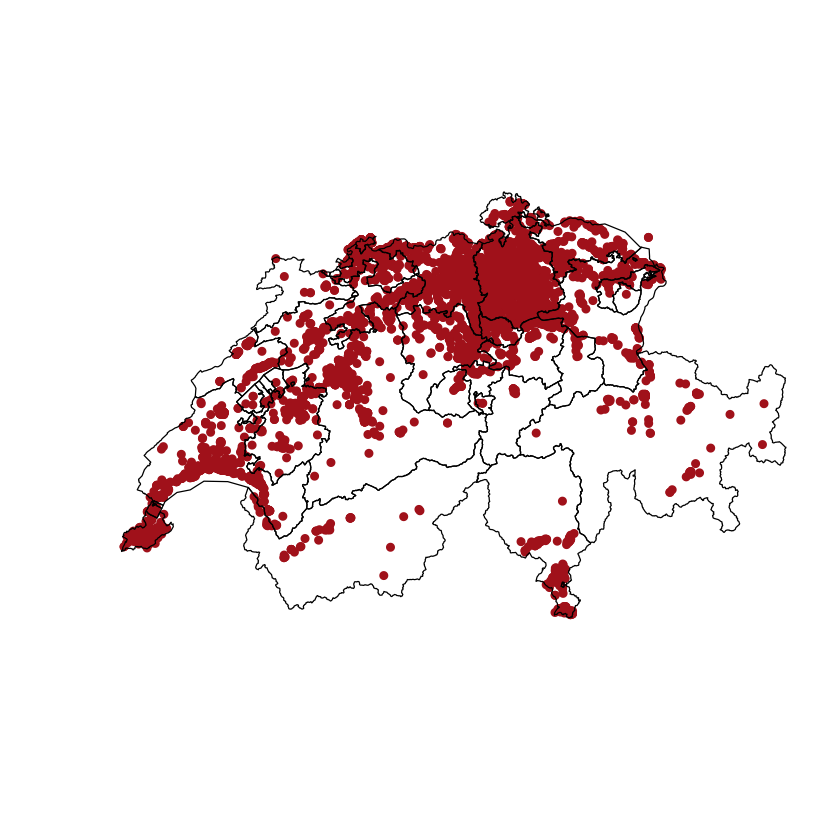

In [64]:
wgs84  = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
cantons = readShapePoly("cantons-vec200-wgs84.shp", IDvar="OBJECTID", proj4string=CRS(wgs84))
plot(apparts_spat, pch=16, col='firebrick')
plot(cantons, add=TRUE)

### Définir les points de régression

Avant de procéder à la régression, nous définissons les endroits où nous voulons faire la régression géographique. Nous allons prendre ici l'exemple d'une grille régulière, car c'est facile à analyser et à visualiser. D'autres façons de faire sont évidemment possibles.

Avant de définir la grille, nous regardons l'étendu de nos donneés:

In [28]:
range(d$lng)
range(d$lat)

[1]  5.973495 10.342740

[1] 45.83232 47.76457

Si nous faisons une grille régulière avec une taille de cellules de 0.1 degrés, nous avons 44 cellules en x, et 20 en y:

In [42]:
(10.3 - 5.9) / 0.1
(47.8 - 45.8) / 0.1

[1] 44

[1] 20

Ça fait donc au total $44 \cdot 20 = 880$ points. Même si c'est assez grossier, ça suffit pour un exemple. Le calcul peut en effet être assez long avec GWR.

Nous pouvons maintenant définir la grille régulière dans R:

In [44]:
regr_pts = SpatialGrid(GridTopology(c(5.9, 45.8), c(0.1, 0.1), c(44, 20)))

Ceci définit une grille avec coordonnées minimum 5.9/45.8, une taille de cellule de 0.1, et 44x20 cellules. On peut afficher la grille dans R:

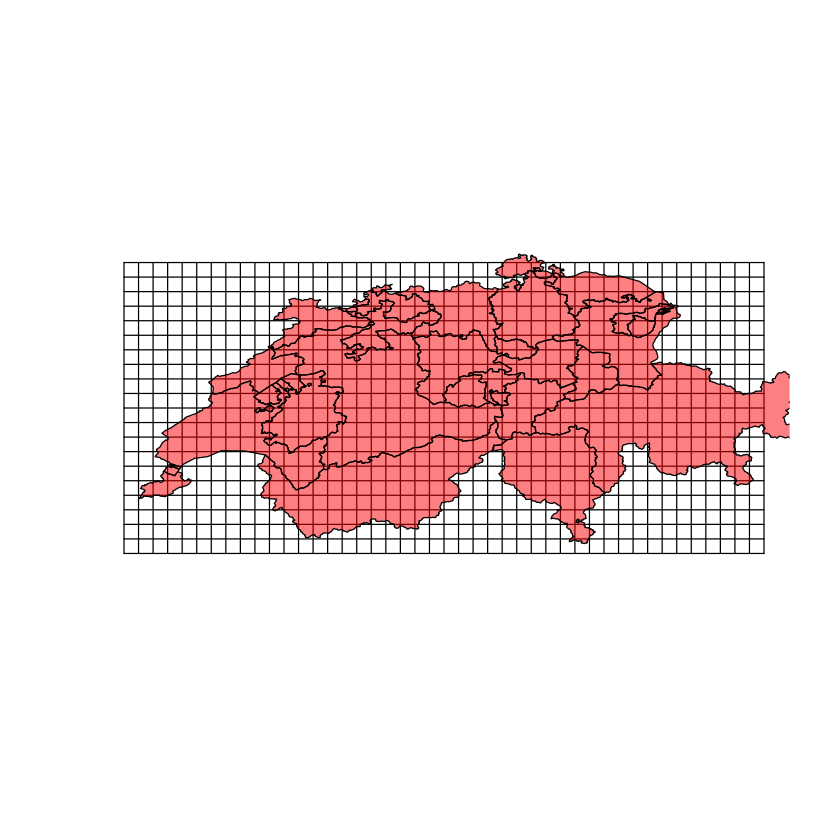

In [45]:
plot(regr_pts)
plot(cantons, add=TRUE, col=adjustcolor('red',alpha.f=0.5))

La grille ne couvre pas certaines parties des cantons des Grisons et de Schaffhouse, car il n'y a pas d'appartements à louer dans notre fichier pour ces régions.

### Calculer le GWR

Avant de procéder au calcul de la régression même, nous devons calculer toutes les distances entre les presque 15'000 appartements et les 880 points de la grille régulière. Le calcul de la distance même peut prendre un peu de temps:

In [66]:
mat_dist = gw.dist(dp.locat=coordinates(apparts_spat), rp.locat=coordinates(regr_pts), longlat=TRUE)

Le paramètre `longlat` permet de calculer des distances de grands cercles au lieu des distances sur un plan 2D.

Maintenant nous pouvons calculer une version simple du GWR:

In [102]:
regr_geo = gwr.basic(
    loyer_mois ~ surface_habitable, 
    data = apparts_spat, 
    regression.points = regr_pts, 
    bw = 5,
    dMat = mat_dist,
    kernel = 'gaussian'
)

Notez que vous pouvez obtenir des avertissements du style

```
warning: solve(): system seems singular; attempting approx solution
```

Ceci est dû à la bandwidth qui peut être trop petite à certains endroits pour avoir suffisamment de points de données pour une régression. Ceci arrive typiquement si nous essayons de faire une régression en dehors de notre région d'étude (p.ex. quelque part en France avec les données sur les appartements suisses).

Nous pouvons afficher simplement quelques premiers résultats du GWR:

In [103]:
print(regr_geo)

   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2017-11-30 08:28:38 
   Call:
   gwr.basic(formula = loyer_mois ~ surface_habitable, data = apparts_spat, 
    regression.points = regr_pts, bw = 5, kernel = "gaussian", 
    dMat = mat_dist)

   Dependent (y) variable:  loyer_mois
   Independent variables:  surface_habitable
   Number of data points: 14572
   ***********************************************************************
   *                    Results of Global Regression                     *
   ***********************************************************************

   Call:
    lm(formula = formula, data = data)

   Residuals:
    Min      1Q  Median      3Q     Max 
-5181.4  -326.0   -84.8   170.8  8718.6 

   Coefficients:
                     Estimate Std. Error t value Pr(>|t

Nous pouvons également obtenir une image du paramètre pour la surface habitable:

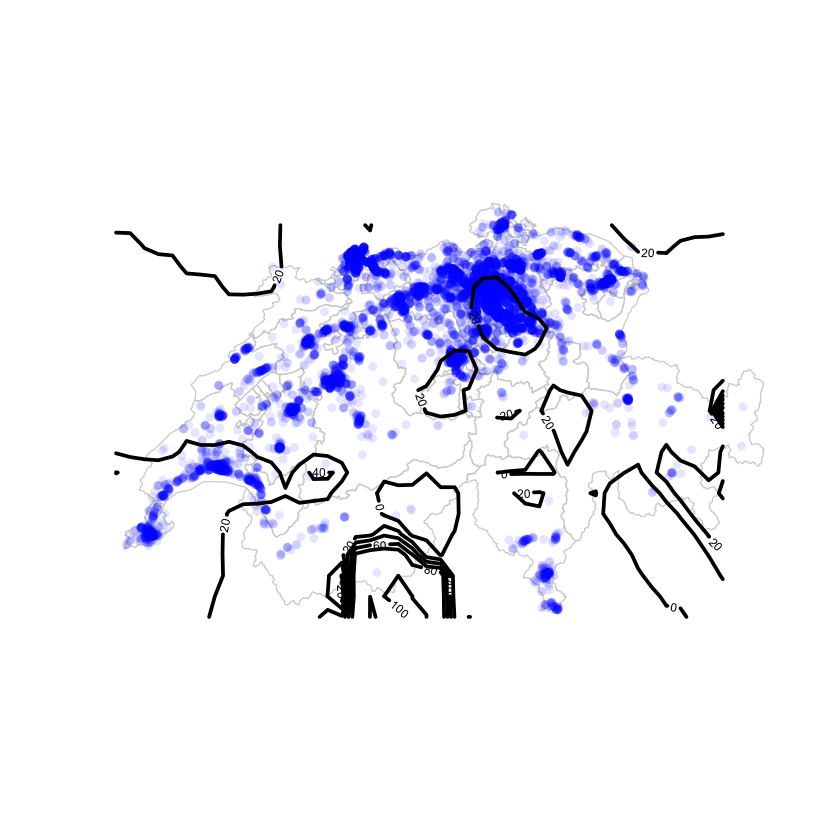

In [104]:
plot(cantons, border='lightgrey')
plot(apparts_spat, add=TRUE, pch=16, col=adjustcolor('blue', alpha.f=0.1))
contour(regr_geo$SDF,'surface_habitable', lwd=3, add=TRUE)

Cette régression permet de faire ressortir les caractéristiques principales du marché immobilier en Suisse. En gros, nous avons un modèle à peu près unique pour la majorité des régions, et quelques points chauds qui sont en gros la région lémanique, Zurich et Zoug. En plus, il y a quelques régions touristiques qui montrent des effets similaires, comme Gstaad, Zermatt ou St-Moritz. Il y a aussi quelques petites abérances qui peuvent être dues à un faible nombre d'appartements dans certaines régions.

Pour améliorer le résultat, on devrait encore travailler un peu:

- limiter les points de régression aux zones avec suffisamment de données
- essayer un noyau adaptif au lieu d'un noyau avec bandwidth fixée
- faire une validation croisée (cross-validation) pour vérifier le résultat

## Les limites du GWR

Le GWR est certainement une méthode puissante pour déterminer des variations spatiales, mais il y a comme dans chaque méthode quelques limites, dont notamment:

- la régression reste une régression linéaire
- le nombre important de modèles rend l'interprétation un peu plus difficile
- les noyaux sont en principe circulaires, une bandwidth plus grande dans une seule direction (p.ex. le long du Léman) n'est pas possible (c'est le problème de l'anisotropie)
- avec un grand nombre de points, la régression devient très lente

Il y a évidemment des recherches qui sont faites pour atténuer ou résoudre ces problèmes. 

Notamment les questions d'interprétation et tests de la pertinence des résultats ont été le sujet de recherches. Un autre volet de recherche qui a reçu un peu d'attention ces dernières années est celui du nombre de points, en essayant de faire des calculs en parallèle (p.ex. Harris et al., 2010). D'autres recherches ont essayé de trouver des méthodes plus rapides au niveau du calcul mais similaire dans la performance (p.ex. Pozdnoukhov et Kaiser, 2011).

## Pour aller plus loin...

Évidemment, il y a de nombreuses ressources sur le Web. Cependant, la référence pour la méthode elle-même est le livre de Fotheringham et al. (2002):

![](figures/gwr-book.jpg)

## Bibliographie

- Fotheringham, A. S., Brunsdon, C., and Charlton, M. (2002). *Geographically Weighted Regression: The Analysis of Spatially Varying Relationships.* John Wiley & Sons.

- Harris, R., Singleton, A., Grose, D., Brunsdon, C. and Longley, P. (2010). Grid-enabling Geographically Weighted Regression: A Case Study of Participation in Higher Education in England. *Transactions in GIS* 14(1), pp. 43-61. DOI:[10.1111/j.1467-9671.2009.01181.x](http://dx.doi.org/10.1111/j.1467-9671.2009.01181.x)

- Pozdnoukhov, A. and Kaiser, C. (2011). Scalable local regression for spatial analytics. In *19th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems*, November 1-4, Chicago, IL.
